In [53]:
import pandas as pd
import numpy as np
import seaborn as sns

from metaflow import Flow, get_metadata
from matplotlib import pyplot as plt

In [64]:
run = Flow('TraderFlow').latest_successful_run
df = run.data.df
df.head()

,A,GOOG,INTC,TSLA,MSFT
Date,,,,,
1999-12-31,47.68,NaN,26.37,NaN,37.56
2000-01-03,44.41,NaN,27.88,NaN,37.50
2000-01-04,41.01,NaN,26.57,NaN,36.23
2000-01-05,38.47,NaN,26.80,NaN,36.61
2000-01-06,37.01,NaN,25.23,NaN,35.38


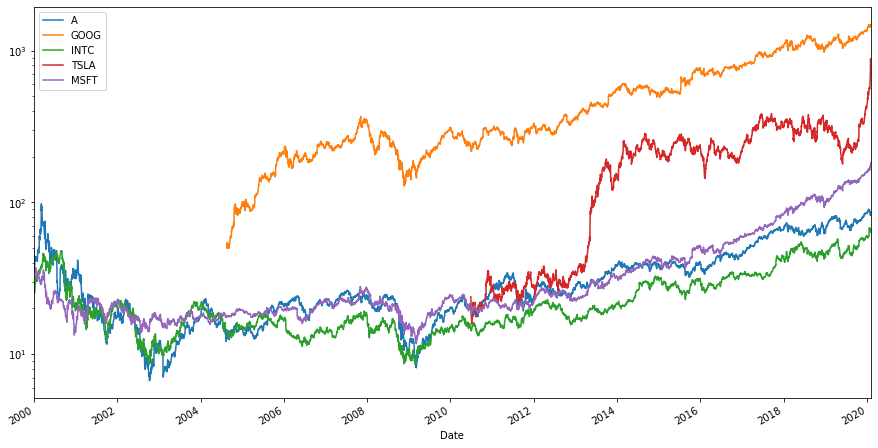

In [66]:
df.plot(figsize=(15,8), logy=True);